In [1]:
pwd

'/content'

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


sns.set(style='white', context='notebook', palette='deep')

In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'colab notebooks/SOA/data_k_mnist'

Mounted at /content/drive


In [28]:
# Load the data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SOA/data_k_mnist/pev/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SOA/data_k_mnist/pev/test.csv')

In [8]:
train.head

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0          1       0       0       0  ...         0         0         0         0
1          0       0       0       0  ...         0         0         0         0
2          1       0       0       0  ...         0         0         0         0
3          4       0       0       0  ...         0         0         0         0
4          0       0       0       0  ...         0         0         0         0
...      ...     ...     ...     ...  ...       ...       ...       ...       ...
41995      0       0       0       0  ...         0         0         0         0
41996      1       0       0       0  ...         0         0         0         0
41997      7       0       0       0  ...         0         0         0         0
41998      6       0       0       0  ...         0         0         0         0
41999      9       0       0       0  ...         0         0       

In [29]:
train.shape

(42000, 785)

In [30]:
test.shape

(28000, 784)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

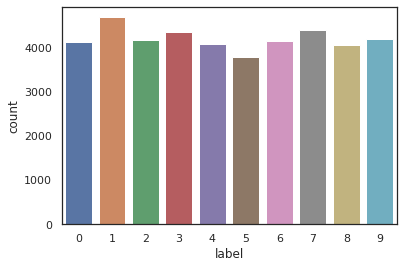

In [31]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [5]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()


count       784
unique        1
top       False
freq        784
dtype: object

In [32]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0


In [33]:

# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [34]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [35]:
# Set the random seed
random_seed = 2

In [36]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [39]:
X_train.shape,Y_train.shape

((37800, 28, 28, 1), (37800, 10))

In [40]:
X_val.shape,Y_val.shape

((4200, 28, 28, 1), (4200, 10))

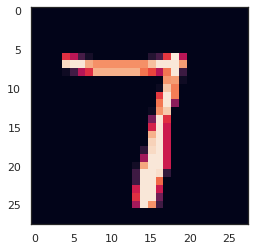

In [10]:
# Some examples
g = plt.imshow(X_train[1][:,:,0])

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.4),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=10, activation='softmax')
])

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)       

In [47]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [54]:
datagen.fit(X_train)

In [53]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)  


model.fit(datagen.flow(X_train, Y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32, epochs=5, verbose=2,
          validation_data = (X_val,Y_val),callbacks=[annealer]
          )


Epoch 1/5
1182/1181 - 20s - loss: 0.1106 - accuracy: 0.9665 - val_loss: 27.5407 - val_accuracy: 0.0914
Epoch 2/5
1182/1181 - 20s - loss: 0.0954 - accuracy: 0.9712 - val_loss: 35.7096 - val_accuracy: 0.0910
Epoch 3/5
1182/1181 - 20s - loss: 0.0978 - accuracy: 0.9701 - val_loss: 35.1152 - val_accuracy: 0.0902
Epoch 4/5
1182/1181 - 21s - loss: 0.0900 - accuracy: 0.9721 - val_loss: 39.7750 - val_accuracy: 0.0910
Epoch 5/5
1182/1181 - 20s - loss: 0.0830 - accuracy: 0.9740 - val_loss: 31.2966 - val_accuracy: 0.0910


the guy

In [30]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (test.shape[0],10) ) 
for j in range(10):
    results = results + model.predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

In [31]:
kaggle competitions submit -c digit-recognizer -f submission.csv -m "Message"

SyntaxError: ignored

predictins


In [ ]:
predictions = model.predict(x=X_test, steps=len(X_test)/32, verbose=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')